In [1]:
%cd ~/code/PaperReproduction/fgcnn/FuxiCTR/demo

import sys
sys.path.append('../')
import os
import logging
from datetime import datetime
from fuxictr import datasets
from fuxictr.datasets.taobao import FeatureEncoder
from fuxictr.features import FeatureMap
from fuxictr.utils import load_config, set_logger, print_to_json
from fuxictr.pytorch.models import FGCNN
from fuxictr.pytorch.torch_utils import seed_everything
import torch

feature_cols = [{'name': ["userid","adgroup_id","pid","cate_id","campaign_id","customer","brand","cms_segid",
                            "cms_group_id","final_gender_code","age_level","pvalue_level","shopping_level","occupation"],
                    'active': True, 'dtype': 'str', 'type': 'categorical'}]
label_col = {'name': 'clk', 'dtype': float}

params = {'model_id': 'FGCNN_demo',
            'dataset_id': 'taobao_tiny',
            'train_data': '../data/tiny_data/train_sample.csv',
            'valid_data': '../data/tiny_data/valid_sample.csv',
            'test_data': '../data/tiny_data/test_sample.csv',
            'model_root': '../checkpoints/',
            'data_root': '../data/',
            'feature_cols': feature_cols,
            'label_col': label_col,
            'embedding_regularizer': 0,
            'net_regularizer': 0,
            'dnn_hidden_units': [128, 64],
            "channels": [14, 16, 18, 20],
            "kernel_heights": [7, 7, 7, 7],
            'hidden_activations': "relu",
            'learning_rate': 1e-3,
            'net_dropout': 0,
            'batch_norm': False,
            'optimizer': 'adam',
            'task': 'binary_classification',
            'loss': 'binary_crossentropy',
            'metrics': ['logloss', 'AUC'],
            'min_categr_count': 1,
            'embedding_dim': 10,
            "pooling_sizes": [2, 2, 2, 2],
            "recombined_channels": [3, 3, 3, 3],
            'batch_size': 1,
            'epochs': 3,
            'shuffle': True,
            'seed': 2019,
            'monitor': 'AUC',
            'monitor_mode': 'max',
            'use_hdf5': True,
            'pickle_feature_encoder': True,
            'save_best_only': True,
            'every_x_epochs': 1,
            'patience': 2,
            'num_workers': 1,
            'data_block_size': -1,
            'verbose': 1,
            'version': 'pytorch',
            'gpu': -1}

set_logger(params)
logging.info(print_to_json(params))
seed_everything(seed=params['seed'])

# Set feature_encoder that defines how to preprocess data
feature_encoder = FeatureEncoder(feature_cols, 
                                    label_col, 
                                    dataset_id=params['dataset_id'], 
                                    data_root=params["data_root"])

# Build dataset from csv to h5
datasets.build_dataset(feature_encoder, 
                        train_data=params["train_data"], 
                        valid_data=params["valid_data"], 
                        test_data=params["test_data"])

# Get feature_map that defines feature specs
feature_map = feature_encoder.feature_map

# Get train and validation data generator from h5
data_dir = os.path.join(params['data_root'], params['dataset_id'])
train_gen, valid_gen = datasets.h5_generator(feature_map, 
                                                stage='train', 
                                                train_data=os.path.join(data_dir, 'train.h5'),
                                                valid_data=os.path.join(data_dir, 'valid.h5'),
                                                batch_size=params['batch_size'],
                                                shuffle=params['shuffle'])

# Model initialization and fitting                                                  
torch_model = FGCNN(feature_map, **params)
# model.count_parameters() # print number of parameters used in model
# model.fit_generator(train_gen, 
#                     validation_data=valid_gen, 
#                     epochs=params['epochs'],
#                     verbose=params['verbose'])
# model.load_weights(model.checkpoint) # reload the best checkpoint

# logging.info('***** validation results *****')
# model.evaluate_generator(valid_gen)

# logging.info('***** validation results *****')
# test_gen = datasets.h5_generator(feature_map, 
#                                     stage='test',
#                                     test_data=os.path.join(data_dir, 'test.h5'),
#                                     batch_size=params['batch_size'],
#                                     shuffle=False)
# model.evaluate_generator(test_gen)

/home/chen/code/PaperReproduction/fgcnn/FuxiCTR/demo


2022-01-17 16:39:47,739 P12470 INFO {
    "batch_norm": "False",
    "batch_size": "1",
    "channels": "[14, 16, 18, 20]",
    "data_block_size": "-1",
    "data_root": "../data/",
    "dataset_id": "taobao_tiny",
    "dnn_hidden_units": "[128, 64]",
    "embedding_dim": "10",
    "embedding_regularizer": "0",
    "epochs": "3",
    "every_x_epochs": "1",
    "feature_cols": "[{'name': ['userid', 'adgroup_id', 'pid', 'cate_id', 'campaign_id', 'customer', 'brand', 'cms_segid', 'cms_group_id', 'final_gender_code', 'age_level', 'pvalue_level', 'shopping_level', 'occupation'], 'active': True, 'dtype': 'str', 'type': 'categorical'}]",
    "gpu": "-1",
    "hidden_activations": "relu",
    "kernel_heights": "[7, 7, 7, 7]",
    "label_col": "{'name': 'clk', 'dtype': <class 'float'>}",
    "learning_rate": "0.001",
    "loss": "binary_crossentropy",
    "metrics": "['logloss', 'AUC']",
    "min_categr_count": "1",
    "model_id": "FGCNN_demo",
    "model_root": "../checkpoints/",
    "monitor

## FuxiCTR-FGCNN

In [73]:
%cd ~/code/PaperReproduction/fgcnn/FuxiCTR
import numpy as np
from torch import nn
import torch
from fuxictr.pytorch.models.base_model import BaseModel
from fuxictr.pytorch.layers import EmbeddingLayer, InnerProductLayer, MLP_Layer
# from fuxictr.pytorch.torch_utils import set_activation

class fuxi_FGCNN(BaseModel):
    def __init__(self, 
                 feature_map, 
                 model_id="FGCNN", 
                 gpu=-1, 
                 task="binary_classification", 
                 learning_rate=1e-3, 
                 embedding_dim=10, 
                 share_embedding=False,
                 channels=[14, 16, 18, 20],
                 kernel_heights=[7, 7, 7, 7],
                 pooling_sizes=[2, 2, 2, 2],
                 recombined_channels=[2, 2, 2, 2],
                 conv_activation="Tanh",
                 conv_batch_norm=True,
                 dnn_hidden_units=[128, 64],
                 dnn_activations="ReLU",
                 dnn_batch_norm=False, 
                 embedding_regularizer=None, 
                 net_regularizer=None,
                 net_dropout=0,
                 **kwargs):
        super(fuxi_FGCNN, self).__init__(feature_map, 
                                    model_id=model_id, 
                                    gpu=gpu, 
                                    embedding_regularizer=embedding_regularizer, 
                                    net_regularizer=net_regularizer,
                                    **kwargs)
        self.share_embedding = share_embedding
        self.embedding_layer = EmbeddingLayer(feature_map, embedding_dim)
        if not self.share_embedding:
            self.fg_embedding_layer = EmbeddingLayer(feature_map, embedding_dim)
        num_fields = feature_map.num_fields
        channels, kernel_heights, pooling_sizes, recombined_channels \
            = self.validate_input(channels, 
                                  kernel_heights, 
                                  pooling_sizes, 
                                  recombined_channels)
        self.fgcnn_layer = FGCNN_Layer(num_fields, 
                                       embedding_dim,
                                       channels=channels, 
                                       kernel_heights=kernel_heights, 
                                       pooling_sizes=pooling_sizes,
                                       recombined_channels=recombined_channels,
                                       activation=conv_activation,
                                       batch_norm=conv_batch_norm)
        input_dim, total_features = self.compute_input_dim(embedding_dim, 
                                                           num_fields, 
                                                           channels, 
                                                           pooling_sizes, 
                                                           recombined_channels)
        self.inner_product_layer = InnerProductLayer(total_features, output="inner_product")
        self.dnn = MLP_Layer(input_dim=input_dim,
                             output_dim=1, 
                             hidden_units=dnn_hidden_units,
                             hidden_activations=dnn_activations,
                             final_activation=nn.Sigmoid(),
                             dropout_rates=net_dropout,
                             batch_norm=dnn_batch_norm)
        self.compile(kwargs["optimizer"], loss=kwargs["loss"], lr=learning_rate)
        self.apply(self.init_weights)

    def compute_input_dim(self, 
                          embedding_dim, 
                          num_fields, 
                          channels, 
                          pooling_sizes, 
                          recombined_channels):
        total_features = num_fields
        input_height = num_fields
        for i in range(len(channels)):
            input_height = int(np.ceil(input_height / pooling_sizes[i]))
            total_features += input_height * recombined_channels[i]
        input_dim = int(total_features * (total_features - 1) / 2) \
                  + total_features * embedding_dim
        return input_dim, total_features

    def validate_input(self, 
                       channels, 
                       kernel_heights, 
                       pooling_sizes, 
                       recombined_channels):
        if not isinstance(kernel_heights, list):
            kernel_heights = [kernel_heights] * len(channels)
        if not isinstance(pooling_sizes, list):
            pooling_sizes = [pooling_sizes] * len(channels)
        if not isinstance(recombined_channels, list):
            recombined_channels = [recombined_channels] * len(channels)
        if not (len(channels) == len(kernel_heights) == len(pooling_sizes) == len(recombined_channels)):
            raise ValueError("channels, kernel_heights, pooling_sizes, and recombined_channels \
                              should have the same length.")
        return channels, kernel_heights, pooling_sizes, recombined_channels

    def forward(self, inputs):
        """
        Inputs: [X, y]
        """
        X, y = self.inputs_to_device(inputs)
        feature_emb = self.embedding_layer(X)
        if not self.share_embedding:
            feature_emb2 = self.fg_embedding_layer(X)
        else:
            feature_emb2 = feature_emb
        conv_in = torch.unsqueeze(feature_emb2, 1) # shape (bs, 1, field, emb)
        # print('fg_input:', conv_in.shape)
        new_feature_emb = self.fgcnn_layer(conv_in)
        return new_feature_emb
        # print('new_features:', new_feature_emb.shape)
        combined_feature_emb = torch.cat([feature_emb, new_feature_emb], dim=1)
        # return combined_feature_emb
        # print('combine_input:', combined_feature_emb.shape)
        inner_product_vec = self.inner_product_layer(combined_feature_emb)
        # return inner_product_vec
        # print('inner_product:', inner_product_vec.shape)
        dense_input = torch.cat([combined_feature_emb.flatten(start_dim=1), inner_product_vec], dim=1)
        # print('dnn_input:', dense_input.shape)
        y_pred = self.dnn(dense_input)
        return_dict = {"y_true": y, "y_pred": y_pred}
        return return_dict


class FGCNN_Layer(nn.Module):
    """
    Input X: tensor of shape (batch_size, 1, num_fields, embedding_dim)
    """
    def __init__(self, 
                 num_fields, 
                 embedding_dim,
                 channels=[3], 
                 kernel_heights=[3], 
                 pooling_sizes=[2],
                 recombined_channels=[2],
                 activation="Tanh",
                 batch_norm=True):
        super(FGCNN_Layer, self).__init__()
        self.embedding_dim = embedding_dim
        conv_list = []
        recombine_list = []
        self.channels = [1] + channels # input channel = 1
        input_height = num_fields
        for i in range(1, len(self.channels)):
            in_channel = self.channels[i - 1]
            out_channel = self.channels[i]
            kernel_height = kernel_heights[i - 1]
            pooling_size = pooling_sizes[i - 1]
            recombined_channel = recombined_channels[i - 1]
            # print('in: %d, out: %d, kernel: %d, pool: %d, recombine: %d' % \
            #     (in_channel, out_channel, kernel_height, pooling_size, recombined_channel))
            conv_list.append(nn.Sequential(
                nn.Conv2d(in_channel, out_channel, 
                        kernel_size=(kernel_height, 1), 
                        padding=(int((kernel_height - 1) / 2), 0)),
                # nn.BatchNorm2d(out_channel),
                nn.Tanh(),
                nn.MaxPool2d((pooling_size, 1), padding=(input_height % pooling_size, 0))
            ))
            input_height = int(np.ceil(input_height / pooling_size))
            input_dim =  input_height * embedding_dim * out_channel
            output_dim = input_height * embedding_dim * recombined_channel
            # print('in: %d, out:%d' % (input_dim, output_dim))
            recombine_layer = nn.Sequential(nn.Linear(input_dim, output_dim),
                                            # nn.Tanh()
                                            )
            recombine_list.append(recombine_layer)
        self.conv_layers = nn.ModuleList(conv_list)
        self.recombine_layers = nn.ModuleList(recombine_list)

    def forward(self, X):
        conv_out = X
        new_feature_list = []
        for i in range(len(self.channels) - 1):
            conv_out = self.conv_layers[i](conv_out)
            flatten_out = torch.flatten(conv_out, start_dim=1)
            # print(i)
            # print('\tflatten_out:', flatten_out.shape)
            recombine_out = self.recombine_layers[i](flatten_out)
            # return recombine_out.reshape(X.size(0), -1, self.embedding_dim)
            # print('\trecombine_out:', recombine_out.shape)
            new_feature_list.append(recombine_out.reshape(X.size(0), -1, self.embedding_dim))
        return conv_out
        new_feature_emb = torch.cat(new_feature_list, dim=1)
        return new_feature_emb

torch_model = fuxi_FGCNN(feature_map, **params)

/home/chen/code/PaperReproduction/fgcnn/FuxiCTR


## paddle-FGCNN

In [74]:
import paddle
import paddle.nn as nn
import numpy as np
from paddle.nn import functional as F


class paddle_FGCNN(nn.Layer):
    def __init__(self, sparse_num_field, sparse_feature_size,
                 sparse_feature_name, sparse_feature_dim, conv_kernel_width,
                 conv_filters, new_maps, pooling_width,
                 dnn_hidden_units, dnn_dropout):
        '''
        Parameters
            sparse_num_field - 
            sparse_feature_size - 
            sparse_feature_name - 
            sparse_feature_dim - 
            conv_kernel_width - 
            conv_filters - 
            new_maps - 
            pooling_width - 
            dnn_hidden_units - 
            dnn_dropout - 
        '''
        super(paddle_FGCNN, self).__init__()
        self.sparse_num_field = sparse_num_field
        self.sparse_feature_size = sparse_feature_size
        self.sparse_feature_name = sparse_feature_name
        self.sparse_feature_dim = sparse_feature_dim
        self.conv_filters = conv_filters
        self.conv_kernel_width = conv_kernel_width
        self.new_maps = new_maps
        self.pooling_width = pooling_width
 
        
        self.fg_embedding = nn.LayerList([
            EmbeddingLayer(
                num_embeddings=self.sparse_feature_size[i],
                embedding_dim=self.sparse_feature_dim,
                feature_name=self.sparse_feature_name[i] + '_fg_emd'
            ) for i in range(self.sparse_num_field)])

        self.embedding = nn.LayerList([
            EmbeddingLayer(
                num_embeddings=self.sparse_feature_size[i],
                embedding_dim=self.sparse_feature_dim,
                feature_name=self.sparse_feature_name[i] + '_emd'
            ) for i in range(self.sparse_num_field)])

        self.fgcnn = FGCNNLayer(self.sparse_num_field, self.sparse_feature_dim,
                                self.conv_filters, self.conv_kernel_width, 
                                self.new_maps, self.pooling_width)
        input_dim = self.compute_input_dim(
            self.sparse_feature_dim,
            self.sparse_num_field,
            self.conv_filters,
            self.pooling_width, 
            self.new_maps,)
        self.dnn_input_dim = input_dim

        self.dnn = DNNLayer(self.dnn_input_dim, dnn_hidden_units, dnn_dropout)

        self.fc_linear = self.add_sublayer(
            name='fc_linear',
            sublayer=nn.Linear(in_features=dnn_hidden_units[-1], out_features=1))

    def compute_input_dim(self, embedding_dim, num_fields, channels, 
                          pooling_sizes, recombined_channels):
        total_features = num_fields
        input_height = num_fields
        for i in range(len(channels)):
            input_height = int(np.ceil(input_height / pooling_sizes[i]))
            total_features += input_height * recombined_channels[i]
        input_dim = int(total_features * (total_features - 1) / 2) \
                  + total_features * embedding_dim
        return input_dim

    def forward(self, inputs):
        inputs = paddle.to_tensor(inputs).reshape((-1, self.sparse_num_field))
        fg_input_list = []
        origin_input_list = []
        for i in range(self.sparse_num_field):
            fg_input_list.append(
                self.fg_embedding[i](inputs[:, i].astype('int64'))
                .reshape((-1, 1, self.sparse_feature_dim)))
            origin_input_list.append(
                self.embedding[i](inputs[:, i].astype('int64'))
                .reshape((-1, 1, self.sparse_feature_dim)))
        fg_input = paddle.concat(fg_input_list, axis=1)
        origin_input = paddle.concat(origin_input_list, axis=1)
        new_features = self.fgcnn(fg_input)
        return new_features
        # print('fg_input:', fg_input.shape)
        # print('new_features:', new_features.shape)
        combined_input = paddle.concat([origin_input, new_features], axis=1)
        # return combined_input
        # print('combine_input:', combined_input.shape)
        # inner product
        embed_list = paddle.split(
            x=combined_input, 
            num_or_sections=combined_input.shape[1], 
            axis=1)
        row = []
        col = []
        num_inputs = len(embed_list)
        for i in range(num_inputs - 1):
            for j in range(i + 1, num_inputs):
                row.append(i)
                col.append(j)
        p = paddle.concat([embed_list[idx] for idx in row], axis=1)  # batch num_pairs k
        q = paddle.concat([embed_list[idx] for idx in col], axis=1)

        inner_product = paddle.sum(p * q, axis=2, keepdim=True)
        inner_product = paddle.flatten(inner_product, start_axis=1)
        # return inner_product
        linear_signal = paddle.flatten(combined_input, start_axis=1)
        # print('linear_signal:', linear_signal.shape)
        # print('inner_prodcut', inner_product.shape)
        dnn_input = paddle.concat([linear_signal, inner_product], axis=1)
        # print('dnn_input:', dnn_input.shape)
        dnn_output = self.dnn(dnn_input)
        dnn_logit = self.fc_linear(dnn_output)
        y_pred = F.sigmoid(dnn_logit)
        return y_pred

class EmbeddingLayer(nn.Layer):
    def __init__(self, num_embeddings, embedding_dim, feature_name):
        super(EmbeddingLayer, self).__init__()
        self.embedding = nn.Embedding(
            num_embeddings=num_embeddings,
            embedding_dim=embedding_dim,
            name=feature_name,
            sparse=True
        )

    def forward(self, inputs):
        return self.embedding(inputs)
    
class FGCNNLayer(nn.Layer):
    def __init__(self, sparse_num_field, embedding_size, filters, kernel_width, new_maps, pooling_width):
        super(FGCNNLayer, self).__init__()
        self.embedding_size = embedding_size
        conv_list = []
        recombine_list = []
        self.filters = [1] + filters # input channel = 1
        input_height = sparse_num_field
        for i in range(1, len(self.filters)):
            in_channel = self.filters[i - 1]
            out_channel = self.filters[i]
            kernel_height = kernel_width[i - 1]
            pooling_size = pooling_width[i - 1]
            recombined_channel = new_maps[i - 1]
            conv_layer = nn.Sequential(
                nn.Conv2D(
                    in_channels=in_channel, 
                    out_channels=out_channel, 
                    kernel_size=(kernel_height, 1), 
                    padding=(int((kernel_height - 1) / 2), 0)),
                # nn.BatchNorm2D(out_channel),
                nn.Tanh(),
                nn.MaxPool2D(
                    kernel_size=(pooling_size, 1), 
                    padding=(input_height % pooling_size, 0)))
            # )
            conv_list.append(conv_layer)

            input_height = int(np.ceil(input_height / pooling_size))
            input_dim =  input_height * embedding_size * out_channel
            output_dim = input_height * embedding_size * recombined_channel
            # print('in: %d, out:%d' % (input_dim, output_dim))
            recombine_layer = nn.Sequential(
                nn.Linear(
                    in_features=input_dim, 
                    out_features=output_dim), 
                # nn.Tanh()
                )
            recombine_list.append(recombine_layer)

        self.conv_layers = nn.LayerList(conv_list)
        self.recombine_layers = nn.LayerList(recombine_list)

    def forward(self, inputs):
        conv_out = inputs.unsqueeze(1)
        new_feature_list = []
        for i in range(len(self.filters) - 1):
            conv_out = self.conv_layers[i](conv_out)
            flatten_out = paddle.flatten(conv_out, start_axis=1)
            recombine_out = self.recombine_layers[i](flatten_out)
            recombine_out = recombine_out.reshape((inputs.shape[0], -1, self.embedding_size))
            # return recombine_out
            new_feature_list.append(recombine_out)
        return conv_out
        new_features = paddle.concat(new_feature_list, axis=1)
        return new_features

class DNNLayer(nn.Layer):
    def __init__(self, inputs_dim, hidden_units, dropout_rate):
        super(DNNLayer, self).__init__()
        self.dropout_rate = dropout_rate
        self.dropout = nn.Dropout(dropout_rate)

        hidden_units = [inputs_dim] + list(hidden_units)
        self.linears = nn.LayerList([nn.Sequential(
            nn.Linear(
                in_features=hidden_units[i], 
                out_features=hidden_units[i + 1],
                name='dnn_%d' % i),
            # nn.BatchNorm(hidden_units[i+1])
            ) for i in range(len(hidden_units) - 1)])
        
        self.activation_layers = nn.LayerList(
            [nn.ReLU(hidden_units[i + 1]) for i in range(len(hidden_units) - 1)])

    def forward(self, inputs):
        for i in range(len(self.linears)):
            inputs = self.linears[i](inputs)
            inputs = self.activation_layers[i](inputs)
            inputs = self.dropout(inputs)
        return inputs

# hyperparameters
sparse_num_field = 14
sparse_feature_size = [25, 95, 3, 48, 98, 97, 66, 10, 10, 3, 6, 3, 4, 3]
sparse_feature_name = ['userid', 'adgroup_id', 'pid', 'cate_id', 'campaign_id', 'customer', 'brand', 'cms_segid', 'cms_group_id', 'final_gender_code', 'age_level', 'pvalue_level', 'shopping_level', 'occupation']
sparse_feature_dim = 10
conv_kernel_width =  [7, 7, 7, 7]
conv_filters =  [14, 16, 18, 20]
new_maps =  [3, 3, 3, 3]
pooling_width =  [2, 2, 2, 2]
dnn_hidden_units =  [128, 64]
dnn_dropout =  0.0
paddle_model = paddle_FGCNN(sparse_num_field, sparse_feature_size,
                 sparse_feature_name, sparse_feature_dim, conv_kernel_width,
                 conv_filters, new_maps, pooling_width,
                 dnn_hidden_units, dnn_dropout)

## pipline

In [4]:
import torch
import pickle
import paddle
# from paddle_net import FGCNN as paddle_FGCNN
from reprod_log import ReprodLogger, ReprodDiffHelper

In [5]:
# path
%cd ~/code/PaperReproduction/fgcnn/fuxi_pipline
# data
pipline_data = pickle.load(open('data/sample.pkl', 'rb'))
# torch
torch_para = torch.load('data/torch_para.pt')

/home/chen/code/PaperReproduction/fgcnn/fuxi_pipline


In [70]:
# name map
name_map = {k:v for k,v in enumerate(sparse_feature_name)}
# fuxi
torch_linear_key = \
    ['dnn.dnn.%d.weight' % i for i in [0, 2, 4]] + \
    ['dnn.dnn.%d.bias' % i for i in [0, 2, 4]] + \
    ['fgcnn_layer.recombine_layers.%d.0.weight' % i for i in range(4)] + \
    ['fgcnn_layer.recombine_layers.%d.0.bias' % i for i in range(4)] + \
    ['fgcnn_layer.conv_layers.%d.1.running_mean' % i for i in range(4)] + \
    ['fgcnn_layer.conv_layers.%d.1.running_var' % i for i in range(4)] 
torch_other_key = \
    ['embedding_layer.embedding_layer.embedding_layer.%s.weight' % v for v in name_map.values()] + \
    ['fg_embedding_layer.embedding_layer.embedding_layer.%s.weight' % v for v in name_map.values()] + \
    ['fgcnn_layer.conv_layers.%d.0.weight' % i for i in range(4)] + \
    ['fgcnn_layer.conv_layers.%d.1.weight' % i for i in range(4)] + \
    ['fgcnn_layer.conv_layers.%d.0.bias' % i for i in range(4)] + \
    ['fgcnn_layer.conv_layers.%d.1.bias' % i for i in range(4)]      

# paddle
paddle_linear_key = \
    ['dnn.linears.%d.0.weight' % i for i in [0, 1]] + ['fc_linear.weight'] + \
    ['dnn.linears.%d.0.bias' % i for i in [0, 1]] + ['fc_linear.bias'] + \
    ['fgcnn.recombine_layers.%d.0.weight' % i for i in range(4)] + \
    ['fgcnn.recombine_layers.%d.0.bias' % i for i in range(4)] + \
    ['fgcnn.conv_layers.%d.1._mean' % i for i in range(4)] + \
    ['fgcnn.conv_layers.%d.1._variance' % i for i in range(4)]
paddle_other_key = \
    ['embedding.%d.embedding.weight' % k for k in name_map.keys()] + \
    ['fg_embedding.%d.embedding.weight' % k for k in name_map.keys()] + \
    ['fgcnn.conv_layers.%d.0.weight' % i for i in range(4)] + \
    ['fgcnn.conv_layers.%d.1.weight' % i for i in range(4)] + \
    ['fgcnn.conv_layers.%d.0.bias' % i for i in range(4)] + \
    ['fgcnn.conv_layers.%d.1.bias' % i for i in range(4)]

# fuxi2paddle
key_map = {key_t:key_p for key_t, key_p in zip(torch_other_key, paddle_other_key)}
paddle_para = {key_map[k]:paddle.to_tensor(v.numpy()) for k, v in torch_para.items() if k in torch_other_key}
for t, p in zip(torch_linear_key, paddle_linear_key):
    if t in torch_para.keys():
        paddle_para[p] = paddle.to_tensor(torch_para[t].T.numpy())

In [44]:
# paddel
p_fgcnn_layer = list(paddle_model.children())[2]
p_recombine_layer = list(p_fgcnn_layer.children())[1]
p_linear_layer = next(next(p_recombine_layer.children()).children())
p_para = p_linear_layer.parameters()[0].numpy()
# torch
t_fgcnn_layer = list(torch_model.children())[2]
t_recombine_layer = list(t_fgcnn_layer.children())[1]
t_linear_layer = next(next(t_recombine_layer.children()).children())
t_para = next(t_linear_layer.parameters()).detach().numpy()

In [55]:
# torch
torch_model.load_state_dict(torch_para)
# paddle
paddle_model.load_dict(paddle_para)

### test
in-out:
- origin_input: ok
- fg_input: ok
- fgcnn_layer:
    - conv:
        - conv2d: ok
        - batchnorm2d: no
        - tanh: no
        - maxpool2d: ok
    - flatten: ok
    - recombine: no

para:
- emb: ok
- fg_emb: ok
- conv: ok
- recombine: ok

In [75]:
torch_para = torch_model.state_dict()
# fuxi2paddle
key_map = {key_t:key_p for key_t, key_p in zip(torch_other_key, paddle_other_key)}
paddle_para = {key_map[k]:paddle.to_tensor(v.numpy()) for k, v in torch_para.items() if k in torch_other_key}
for t, p in zip(torch_linear_key, paddle_linear_key):
    if t in torch_para.keys():
        paddle_para[p] = paddle.to_tensor(torch_para[t].T.numpy())

# torch
torch_model.load_state_dict(torch_para)
# paddle
paddle_model.load_dict(paddle_para)

torch_model.eval()
paddle_model.eval()
data, label = pipline_data[0][:-1], pipline_data[0][-1]
# torch
torch_inputs = list(map(torch.tensor, [data.reshape((1,-1)), label]))
# torch_out = torch_model.forward(torch_inputs)['y_pred'].detach().numpy()
torch_out = torch_model.forward(torch_inputs).detach().numpy()
# paddle
paddle_out = paddle_model.forward(data).numpy()
# diff
diff = (torch_out - paddle_out).flatten()

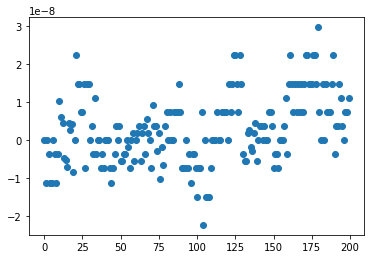

In [76]:
import matplotlib.pyplot as plt
plt.scatter(range(len(diff)), diff)
plt.show()

max: 0.0


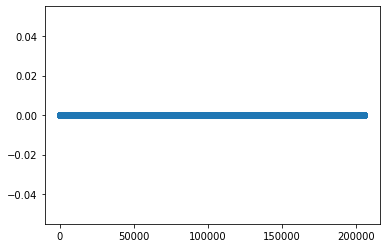

In [40]:
# para
p_p = paddle_model.state_dict()['fgcnn.recombine_layers.0.0.weight'].numpy().T
t_p = torch_model.state_dict()['fgcnn_layer.recombine_layers.0.0.weight'].detach().numpy()
diff_p = (p_p - t_p).flatten()
print('max:', max(diff_p))
plt.scatter(range(len(diff_p)), diff_p)
plt.show()

### step1

In [85]:
torch_model.eval()
paddle_model.eval()
torch_forward = []
paddle_forward = []
for data in pipline_data:
    data, label = data[:-1], data[-1]
    # torch
    torch_inputs = list(map(torch.tensor, [data.reshape((1,-1)), label]))
    torch_out = torch_model.forward(torch_inputs)
    torch_forward.append(torch_out['y_pred'].detach().numpy())
    # paddle
    paddle_out = paddle_model.forward(data)
    paddle_forward.append(paddle_out.numpy())

# torch
reprod_logger = ReprodLogger()
reprod_logger.add("logits", np.array(torch_forward))
reprod_logger.save("step1/forward_torch.npy")
# paddle
reprod_logger = ReprodLogger()
reprod_logger.add("logits", np.array(paddle_forward))
reprod_logger.save("step1/forward_paddle.npy")
# diff
diff_helper = ReprodDiffHelper()
torch_info = diff_helper.load_info("step1/forward_torch.npy")
paddle_info = diff_helper.load_info("step1/forward_paddle.npy")

diff_helper.compare_info(torch_info, paddle_info)

diff_helper.report(path="diff/forward_diff.log")

[2022/01/12 16:21:19] root INFO: logits: 
[2022/01/12 16:21:19] root INFO: 	mean diff: check passed: True, value: 1.7285346487483366e-08
[2022/01/12 16:21:19] root INFO: diff check passed
